In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm 
import numpy as np
import pandas as pd
from tqdm import tqdm

### Functions

In [2]:
def ll2utm(*args):
    """
    Converts Latitude and Longitude (degrees) to UTM coordinates (meters).
    Usage:
        x, y = ll2utm(lat, lon)
        x, y = ll2utm(np.array([[lat1, lon1], [lat2, lon2]]))
        x, y, zone = ll2utm(lat, lon, datum='wgs84')
        x, y, zone = ll2utm(lat, lon, [a, f])
        x, y, zone = ll2utm(lat, lon, zone=18)
    """

    # Constants
    D0 = 180.0 / np.pi
    K0 = 0.9996
    X0 = 500000.0

    # Datum dictionary
    datums = {
        'wgs84': (6378137.0, 298.257223563),
        'nad83': (6378137.0, 298.257222101),
        'grs80': (6378137.0, 298.257222101),
        'nad27': (6378206.4, 294.978698214),
        'int24': (6378388.0, 297.0),
        'clk66': (6378206.4, 294.978698214),
    }

    # Argument parsing
    datum = 'wgs84'
    zone = None

    if len(args) < 1:
        raise ValueError("Not enough input arguments")

    if len(args) > 1 and isinstance(args[0], (float, int, np.ndarray)):
        lat, lon = args[0], args[1]
        idx = 2
    elif isinstance(args[0], np.ndarray) and args[0].shape[1] == 2:
        lat, lon = args[0][:, 0], args[0][:, 1]
        idx = 1
    else:
        raise ValueError("Input must be (lat, lon) or a 2-column array")

    lat = np.asarray(lat)
    lon = np.asarray(lon)

    # Remaining optional args
    for arg in args[idx:]:
        if isinstance(arg, str) or (isinstance(arg, (list, tuple, np.ndarray)) and len(arg) == 2):
            datum = arg
        elif isinstance(arg, (int, np.integer, np.ndarray)):
            zone = arg
        else:
            raise ValueError("Unknown argument type: {}".format(arg))

    # Datum conversion
    if isinstance(datum, str):
        datum = datum.lower()
        if datum not in datums:
            raise ValueError(f"Unknown DATUM name {datum}")
        A1, F1 = datums[datum]
    else:
        A1, F1 = datum

    # Coordinate conversion
    p1 = lat / D0
    l1 = lon / D0

    if zone is None:
        F0 = np.round((l1 * D0 + 183) / 6).astype(int)
    else:
        F0 = np.abs(zone)

    B1 = A1 * (1 - 1/F1)
    E1 = np.sqrt((A1**2 - B1**2) / A1**2)
    P0 = 0.0 / D0
    L0 = (6 * F0 - 183) / D0
    Y0 = np.where(p1 < 0, 1e7, 0.0)
    N = K0 * A1

    C = coef(E1, mode=0)
    B = C[0]*P0 + C[1]*np.sin(2*P0) + C[2]*np.sin(4*P0) + C[3]*np.sin(6*P0) + C[4]*np.sin(8*P0)
    YS = Y0 - N * B

    C = coef(E1, mode=2)
    L = np.log(np.tan(np.pi/4 + p1/2) * ((1 - E1*np.sin(p1)) / (1 + E1*np.sin(p1)))**(E1/2))
    z = np.arctan(np.sinh(L) / np.cos(l1 - L0)) + 1j * np.log(np.tan(np.pi/4 + np.arcsin(np.sin(l1 - L0) / np.cosh(L)) / 2))
    Z = N * (C[0]*z + C[1]*np.sin(2*z) + C[2]*np.sin(4*z) + C[3]*np.sin(6*z) + C[4]*np.sin(8*z))

    xs = np.imag(Z) + X0
    ys = np.real(Z) + YS

    # Return zone
    if len(args) >= 3:
        f = F0 * np.sign(lat)
        if np.all(f == f[0]):
            f = f[0]
        return xs, ys, f
    else:
        return xs, ys

def coef(e, mode=0):
    """Projection coefficients"""
    if mode == 0:
        c0 = [[-175/16384, 0, -5/256, 0, -3/64, 0, -1/4, 0, 1],
              [-105/4096, 0, -45/1024, 0, -3/32, 0, -3/8, 0, 0],
              [525/16384, 0, 45/1024, 0, 15/256, 0, 0, 0, 0],
              [-175/12288, 0, -35/3072, 0, 0, 0, 0, 0, 0],
              [315/131072, 0, 0, 0, 0, 0, 0, 0, 0]]
    elif mode == 1:
        c0 = [[-175/16384, 0, -5/256, 0, -3/64, 0, -1/4, 0, 1],
              [1/61440, 0, 7/2048, 0, 1/48, 0, 1/8, 0, 0],
              [559/368640, 0, 3/1280, 0, 1/768, 0, 0, 0, 0],
              [283/430080, 0, 17/30720, 0, 0, 0, 0, 0, 0],
              [4397/41287680, 0, 0, 0, 0, 0, 0, 0, 0]]
    else:
        c0 = [[-175/16384, 0, -5/256, 0, -3/64, 0, -1/4, 0, 1],
              [-901/184320, 0, -9/1024, 0, -1/96, 0, 1/8, 0, 0],
              [-311/737280, 0, 17/5120, 0, 13/768, 0, 0, 0, 0],
              [899/430080, 0, 61/15360, 0, 0, 0, 0, 0, 0],
              [49561/41287680, 0, 0, 0, 0, 0, 0, 0, 0]]

    c = np.zeros(5)
    for i in range(5):
        c[i] = np.polyval(c0[i], e)
    return c


## Divergence 1D

$du/dx$ + $dv/dy$ + $dw/dz$ = 0

In [2]:
# Cargar datos
ds = xr.open_dataset(r'../data/amazon2.nc')
# lon = ds['longitude'].values
# lat = ds['latitude'].values
# uvel = ds['uo'].values
# vvel = ds['vo'].values
# time = ds['time'].values
# depth = ds['depth'].values

# # Extraer u y v para el primer tiempo
# u = uvel[:, :, :, 0]
# v = vvel[:, :, :, 0]

(-1.0, 1.0)

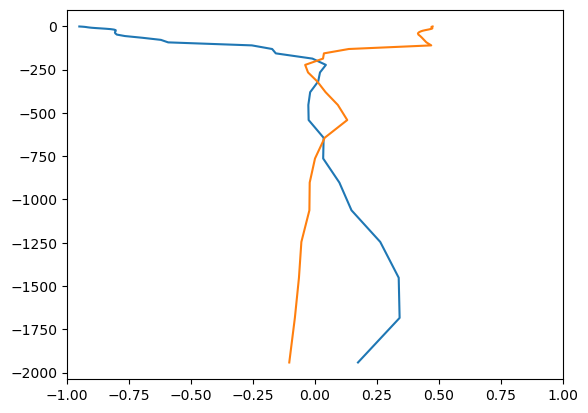

In [4]:
ii=100
u=ds.uo.isel(time=0,latitude=ii,longitude=ii).data
v=ds.vo.isel(time=0,latitude=ii,longitude=ii).data

plt.plot(u,-ds.depth)
plt.plot(v,-ds.depth)
plt.xlim(-1,1)

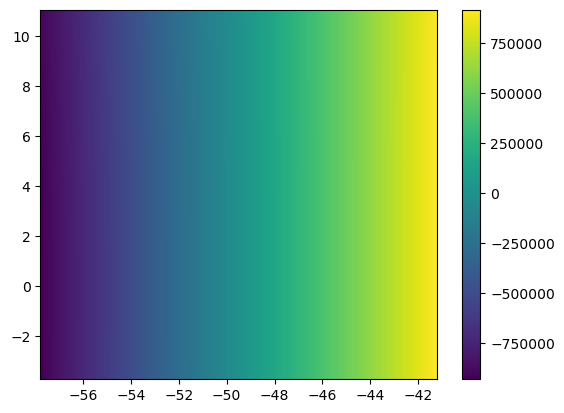

In [57]:
plt.pcolormesh(LON,LAT,x)
plt.colorbar()

In [5]:
# Convertir lat/lon a UTM
LON, LAT = np.meshgrid(ds.longitude.values, ds.latitude.values)
x, y,_ = ll2utm(LAT, LON, 'wgs84', 23)

In [7]:
dx, _ = np.gradient(x)
_, dy = np.gradient(y)
dz = np.gradient(ds.depth)

In [44]:
dy.shape

(177, 199)

In [27]:
dudx = np.gradient(u) / dx[100, 100]
dvdy = np.gradient(v) / dy[100, 100]
rhs = -(dudx + dvdy)


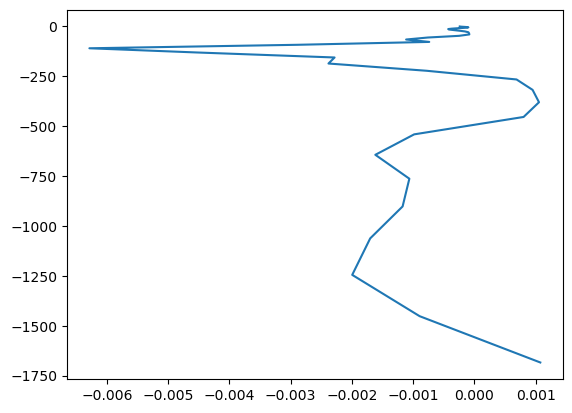

In [30]:
plt.plot(rhs,-ds.depth)

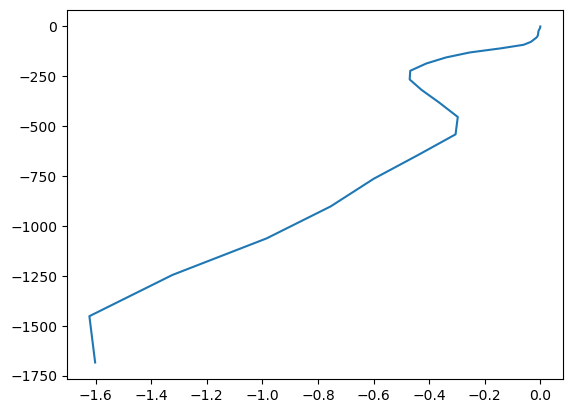

In [38]:
w = cumulative_trapezoid(rhs, ds.depth, initial=0)
plt.plot(w,-ds.depth)

In [41]:
w = np.zeros_like(u)
for k in range(1, len(ds.depth)):
    w[:, :, k] = w[:, :, k-1] - div_h[:, :, k-1] * dz[k-1]

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [24]:
ds.depth.shift(depth=-1) - ds.depth

<xarray.DataArray 'depth' (depth: 50)>
array([  1.04735  ,   1.104294 ,   1.173826 ,   1.2587292,   1.36239  ,
         1.488946 ,   1.6434369,   1.8320026,   2.0621405,   2.3429298,
         2.6854897,   3.10326  ,   3.6125908,   4.23332  ,   4.98942  ,
         5.9099007,   7.02964  ,   8.390598 ,  10.042976 ,  12.046585 ,
        14.472221 ,  17.403229 ,  20.936699 ,  25.184692 ,  30.274902 ,
        36.34961  ,  43.56511  ,  52.087097 ,  62.0856   ,  73.7247   ,
        87.151215 , 102.477844 , 119.76636  , 139.00616  , 160.10065  ,
       182.85107  , 206.95996  , 232.03308  , 257.6089   , 283.18494  ,
       308.25806  , 332.36694  , 355.1172   , 376.2119   , 395.4519   ,
       412.74023  , 428.0669   , 441.49316  , 453.1328   ,         nan],
      dtype=float32)
Coordinates:
  * depth    (depth) float32 0.494 1.541 2.646 ... 4.833e+03 5.275e+03 5.728e+03

In [58]:
ds.depth

<xarray.DataArray 'depth' (depth: 50)>
array([4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00, 5.078224e+00,
       6.440614e+00, 7.929560e+00, 9.572997e+00, 1.140500e+01, 1.346714e+01,
       1.581007e+01, 1.849556e+01, 2.159882e+01, 2.521141e+01, 2.944473e+01,
       3.443415e+01, 4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02, 1.558507e+02,
       1.861256e+02, 2.224752e+02, 2.660403e+02, 3.181274e+02, 3.802130e+02,
       4.539377e+02, 5.410889e+02, 6.435668e+02, 7.633331e+02, 9.023393e+02,
       1.062440e+03, 1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03, 3.597032e+03,
       3.992484e+03, 4.405224e+03, 4.833291e+03, 5.274784e+03, 5.727917e+03],
      dtype=float32)
Coordinates:
  * depth    (depth) float32 0.494 1.541 2.646 ... 4.833e+03 5.275e+03 5.728e+03
Attributes:
    standard_name:  depth
    long_name:      Depth
    units:          m
    unit_long:      Meters
    axis:           Z
    positive:       down

## Divergence 2D
* 3 neighboars and 5 depths

### Simulated Data

In [115]:
# Reconstrucción de los datos u, v, z desde los datos previos
# Se utilizarán los datos como arrays literales (simulados aquí como ejemplo representativo)
# En la implementación real, se cargarían directamente desde variables previas o archivos

# Datos reducidos por límite de contexto; en una implementación completa,
# se deben pegar aquí directamente los arrays u y v completos de tamaño (50, 2, 2)

# Por ahora generaremos arrays de ejemplo con NaNs en la parte inferior
nz, ny, nx = 50, 2, 2
z = np.array([
    4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00, 5.078224e+00,
    6.440614e+00, 7.929560e+00, 9.572997e+00, 1.140500e+01, 1.346714e+01,
    1.581007e+01, 1.849556e+01, 2.159882e+01, 2.521141e+01, 2.944473e+01,
    3.443415e+01, 4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
    7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02, 1.558507e+02,
    1.861256e+02, 2.224752e+02, 2.660403e+02, 3.181274e+02, 3.802130e+02,
    4.539377e+02, 5.410889e+02, 6.435668e+02, 7.633331e+02, 9.023393e+02,
    1.062440e+03, 1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
    2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03, 3.597032e+03,
    3.992484e+03, 4.405224e+03, 4.833291e+03, 5.274784e+03, 5.727917e+03
], dtype=np.float32)

# Para la demostración, se crean arrays aleatorios con NaNs en los últimos niveles
np.random.seed(0)
u = np.random.uniform(-1, 1, size=(nz, ny, nx)).astype(np.float32)
v = np.random.uniform(-1, 1, size=(nz, ny, nx)).astype(np.float32)
u[-10:] = np.nan
v[-10:] = np.nan

# Paso 1: calcular divergencia horizontal
dx = dy = 9200.0  # en metros
A = 6371.0e3
# dy = np.deg2rad(ds.latitude.shift(latitude=-1) - ds.latitude) * A
# dx = (
#     np.deg2rad(ds.longitude.shift(longitude=-1) - ds.longitude) * A
#     * np.cos(np.deg2rad(ds.latitude))
# )

In [116]:
dudx = np.gradient(u, dx, axis=2)
dvdy = np.gradient(v, dy, axis=1)

div_h = dudx + dvdy  # (nz, ny, nx)

# Paso 2: integración vertical de -div_h sobre z (ignorando niveles con NaN)
dz = np.gradient(z)
w = np.full_like(div_h, np.nan)
nz, ny, nx = div_h.shape

for j in range(ny):
    for i in range(nx):
        w_col = np.zeros(nz)
        for k in range(1, nz):
            if np.isnan(div_h[k - 1, j, i]) or np.isnan(w_col[k - 1]):
                w_col[k:] = np.nan
                break
            w_col[k] = w_col[k - 1] - div_h[k - 1, j, i] * dz[k - 1]
        w[:, j, i] = w_col

# # Mostrar resultados del primer punto horizontal
df = pd.DataFrame({
    "depth [m]": z,
    "w(j=0,i=0) [m/s]": w[:, 0, 0],
    "w(j=0,i=1) [m/s]": w[:, 0, 1],
    "w(j=1,i=0) [m/s]": w[:, 1, 0],
    "w(j=1,i=1) [m/s]": w[:, 1, 1],
})
# tools.display_dataframe_to_user(name="Vertical velocity profiles (w) for all grid points", dataframe=df)

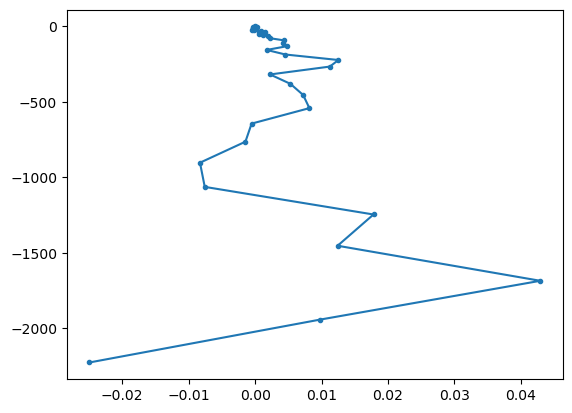

In [117]:
plt.plot(w[:,0,1],-ds.depth,marker=".")

In [108]:
df

,depth [m],"w(j=0,i=0) [m/s]","w(j=0,i=1) [m/s]","w(j=1,i=0) [m/s]","w(j=1,i=1) [m/s]"
0,0.494025,0.000000,0.000000,0.000000,0.000000
1,1.541375,4.643846,-39.994255,5.194847,-39.443249
2,2.645669,55.601551,-10.146116,55.567165,-10.180500
3,3.819495,94.956581,-65.230461,94.074066,-66.112961
4,5.078224,36.784752,-22.209459,36.876530,-22.117676
5,6.440614,60.005753,18.197420,62.312840,20.504509
6,7.929560,23.541613,11.018132,24.181419,11.657944
7,9.572997,79.115044,-75.358582,78.727295,-75.746330
8,11.405000,-8.584055,-140.702377,-11.486504,-143.604828
9,13.467140,-53.349445,-84.388680,-58.474358,-89.513588


### Real Data

In [4]:
# u=ds.uo.isel(time=0,latitude=slice(98,100),longitude=slice(98,100)).data
# v=ds.vo.isel(time=0,latitude=slice(98,100),longitude=slice(98,100)).data
A = 6371.0e3

u=ds.uo.isel(time=0)
v=ds.vo.isel(time=0)

dy = np.deg2rad(ds.latitude.shift(latitude=-1) - ds.latitude) * A
dx = (
    np.deg2rad(ds.longitude.shift(longitude=-1) - ds.longitude) * A
    * np.cos(np.deg2rad(ds.latitude)))

In [6]:
# dudx = np.gradient(u, dx, axis=2)
# dvdy = np.gradient(v, dy, axis=1)

nz, ny, nx = 50, 177, 199

dudx = (u.shift(longitude=-1) - u) / dx
dvdy = (v.shift(latitude=-1) - v) / dy

div_h = dudx + dvdy  # (nz, ny, nx)

# Paso 2: integración vertical de -div_h sobre z (ignorando niveles con NaN)
dz = np.gradient(ds.depth)
w = np.full_like(div_h, np.nan)
nz, ny, nx = div_h.shape

In [140]:
for j in tqdm(range(ny), desc="Integrating w by column"):
    for i in range(nx):
        w_col = np.zeros(nz)
        for k in range(1, nz):
            if np.isnan(div_h[k - 1, j, i]) or np.isnan(w_col[k - 1]):
                w_col[k:] = np.nan
                break
            w_col[k] = w_col[k - 1] - div_h[k - 1, j, i] * dz[k - 1]
        w[:, j, i] = w_col

Integrating w by column: 100%|██████████| 177/177 [09:02<00:00,  3.06s/it]


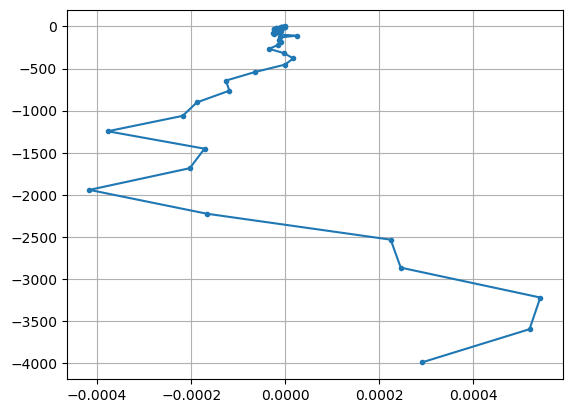

In [150]:
plt.plot(w[:,120,120],-ds.depth,marker=".")
plt.grid()

In [144]:
# w_da = xr.DataArray(
#     data=w,
#     dims=["depth", "lat", "lon"],
#     coords={
#         "depth": ds.depth.data,
#         "lat": ds.latitude.data,
#         "lon": ds.longitude.data
#     },
#     name="w"
# )

# w_da.attrs["units"] = "m/s"
# w_da.attrs["long_name"] = "Vertical velocity"

# w_da.to_netcdf("w.nc")


In [145]:
w_da

<xarray.DataArray 'w' (depth: 50, lat: 177, lon: 199)>
array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
...
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan]]], dtype=float32)
Coordinates:
  * depth    (depth) float32 0.494 1.541 2.646 ... 4.833e+03 5.275e+03 5.728e+03
  * lat      (lat) float32 -3.667 -3.583 -3.5 -3.417 ... 10.75 10.83 10.92 11.0
  * lon      (lon) float32 -57.75 -57.67 -57.58 -57.5 ... -41.42 -41.33 -41.25
Attributes:
    units:      m/s
    long_name:  Vertical velocity

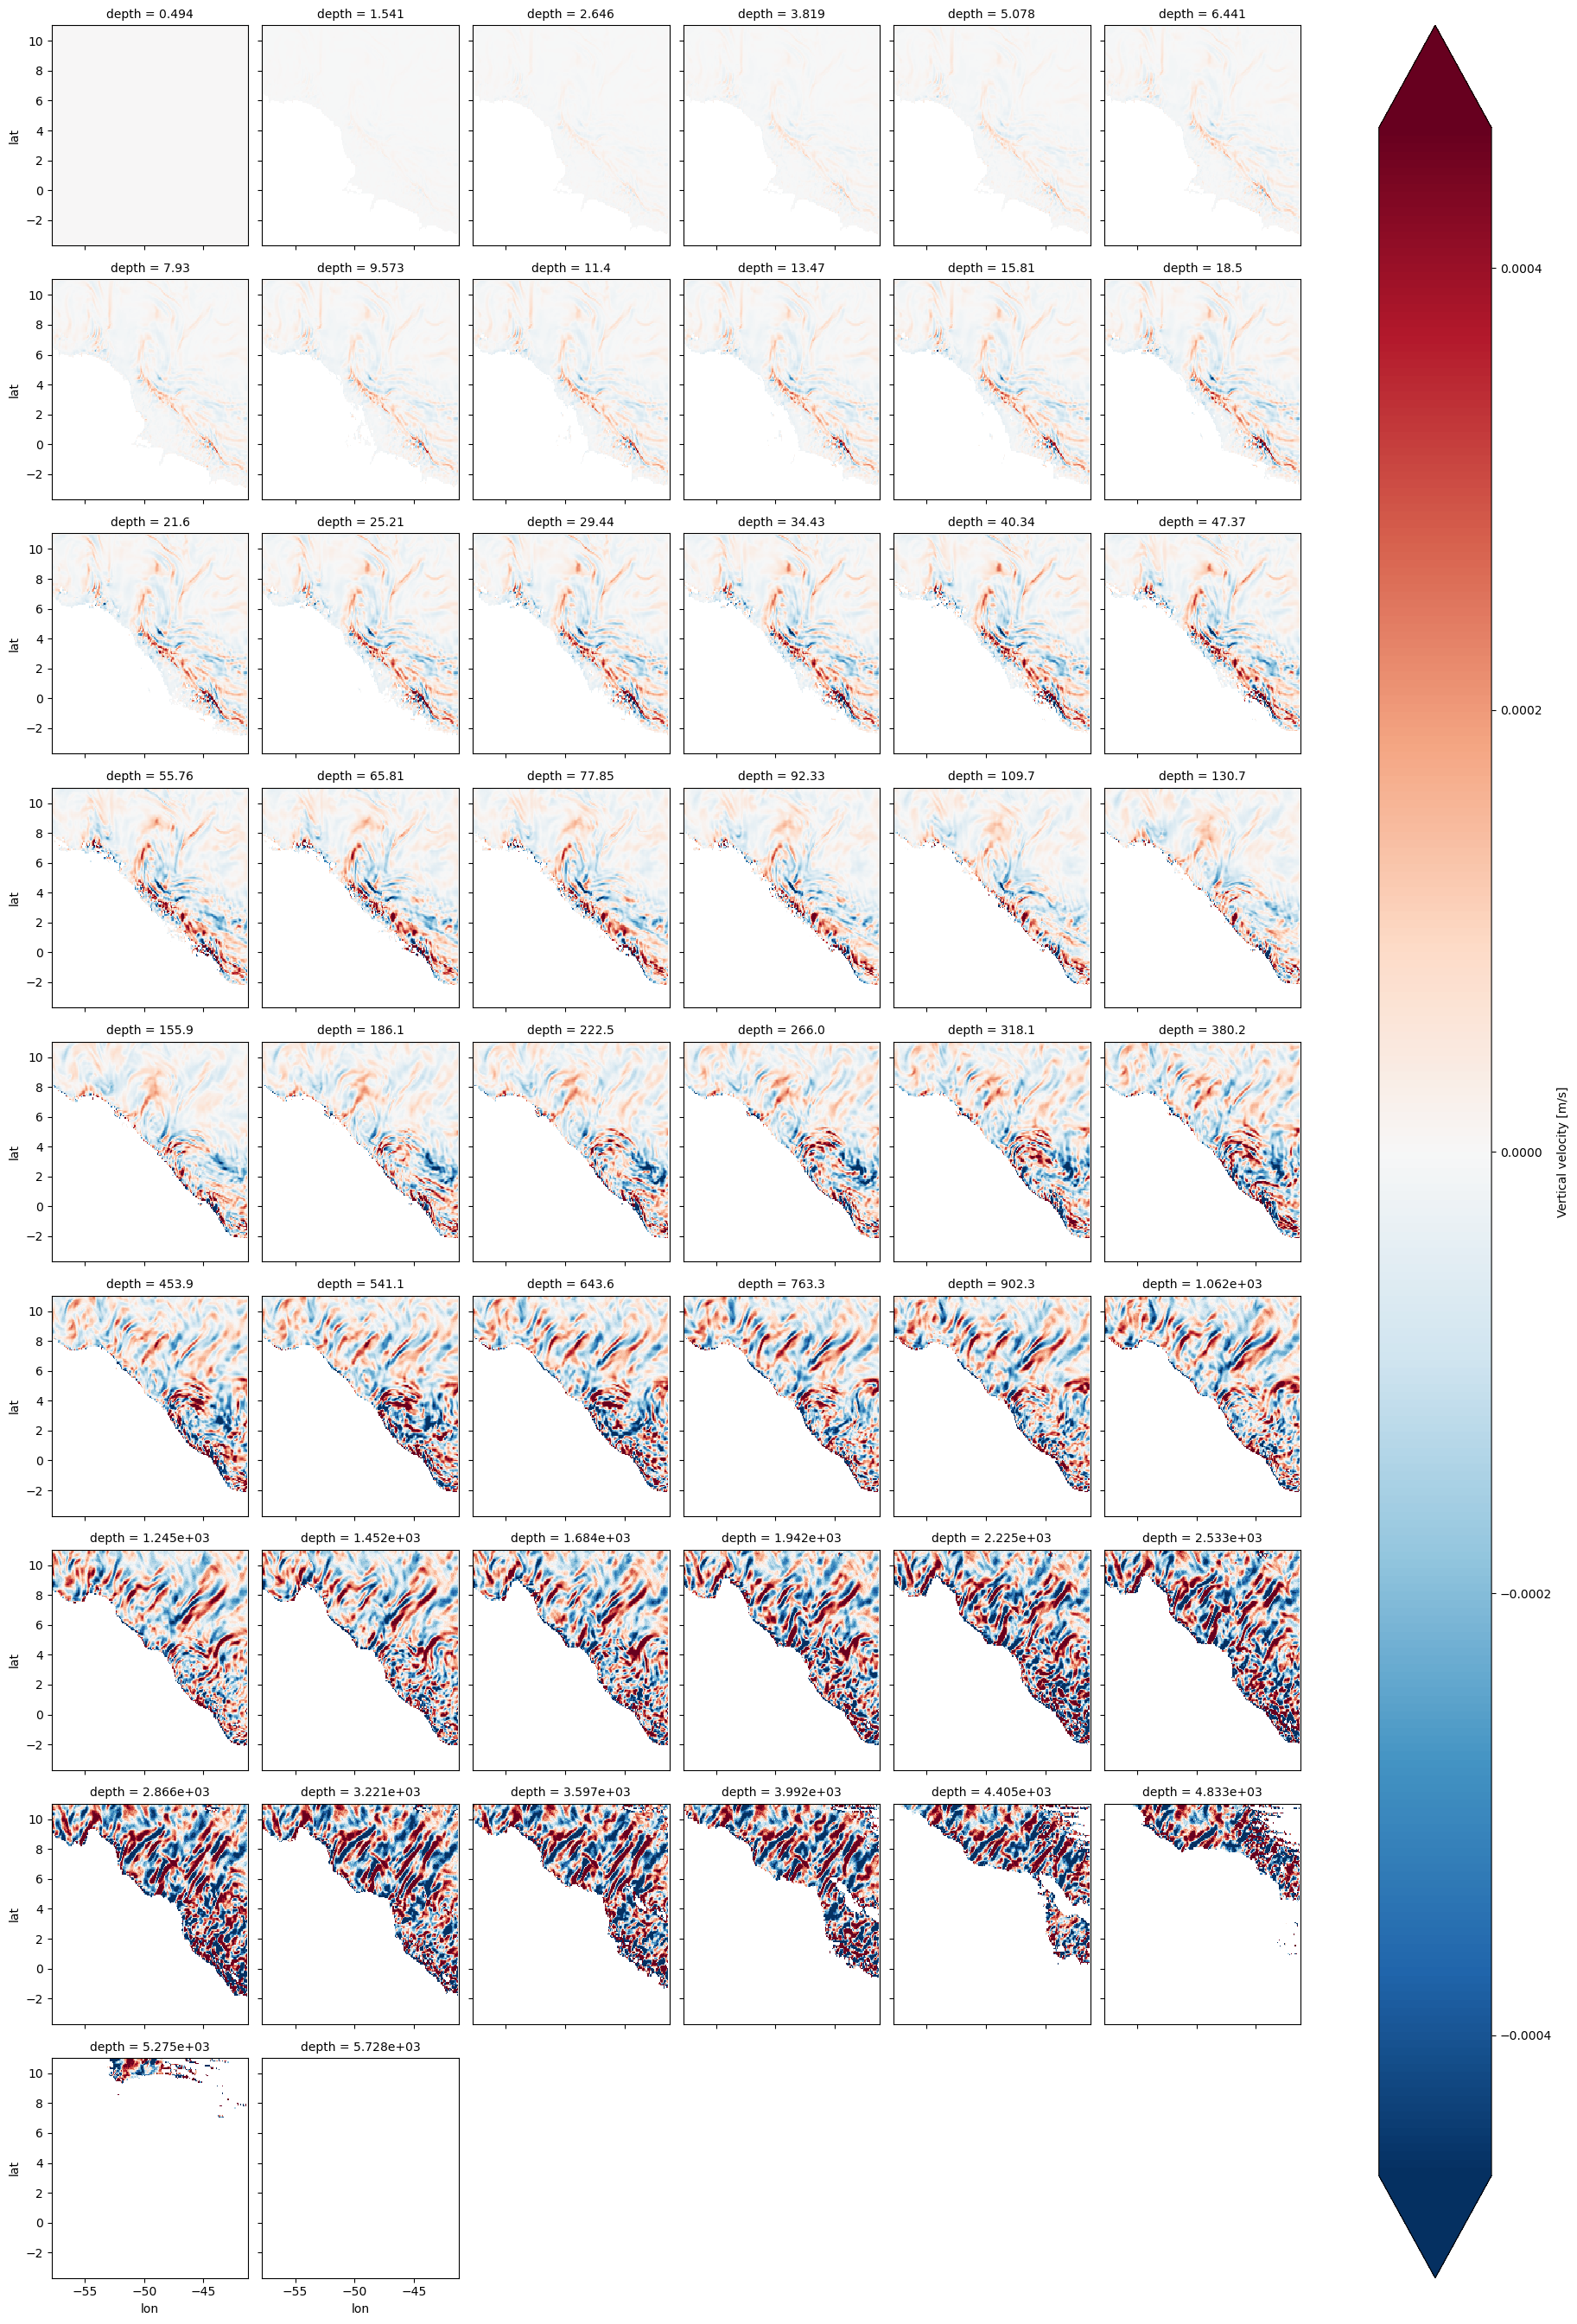

In [152]:
w_da.plot(x='lon',y='lat',col='depth',col_wrap=6, robust=True)
# plt.savefig('Figures/div_w.png',format='png', 
#             dpi=300, transparent=False,bbox_inches='tight')

#### Things I need to add
* I connected the edges instead of the middle values, do the same calculation for the middle values of dx, dy, dz, dudx, dvdy --- partially done

* Speed up the calculation of W, use xarray instead of loops -- done 

  
* place the w correctly in the middle and not in the edges -- in progress

  
* Check for the influence of the Deep Western Boundary Current

* * flows southward along the western boundary of the South Atlantic, bringing deep, cold, and dense waters from the North Atlantic. The DWBC is a major component of the Atlantic Meridional Overturning Circulation (AMOC), playing a crucial role in transporting heat and energy across the Atlantic.
